In [1]:
import Dates
println("Last updated: ", Dates.now())

Last updated: 2020-07-15T11:44:24.321


In [2]:
# Load environment
import Pkg; Pkg.activate("../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


# NOTE
Probably will need to look into Turing `Bijectors`: https://github.com/TuringLang/Bijectors.jl

In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Turing.RandomMeasures: stickbreak
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import LinearAlgebra

In [92]:
eye(n::Int) = Matrix{Float64}(LinearAlgebra.I(n))

4×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [51]:
function mvnormlogpdf(x, m, S)
    K = length(m)
    z = (x - m)
    log_numer = -z' * inv(S) * z / 2
    log_denom = K * log(2*pi) + LinearAlgebra.logdet(S)
    log_denom /= 2
    return log_numer - log_denom
end

rand_covmat(d) = let
    L = LinearAlgebra.LowerTriangular(randn(d, d))
    L*L' 
end

# m = randn(3)
# S = rand_covmat(3)
# x = randn(3)
# logpdf(MvNormal(m, S), x), mvnormlogpdf(x, m, S)

rand_covmat (generic function with 1 method)

In [54]:
function mix_mvnorm_logpdf(X, m, S, w)
    # Number of observations
    N = size(X, 1)
    
    # D: Data dimension
    # K: Number of mixture components
    D, K = size(m)
    
    out = 0.0
    for i in 1:N
        ll = [mvnormlogpdf(X[i, :], m[:, k], S[k]) for k in 1:K]
        out += logsumexp(ll + log.(w))
    end
    
    return out
end

# x = randn(10, 3)
# m = randn(3, 5)
# S = [rand_covmat(3) for _ in 1:5]
# w = stickbreak(rand(4))
# mix_mvnorm_logpdf(x, m, S, w)

-59.707116675832324

In [72]:
function vtoL(v, n)
    L = zeros(n, n) 
    k = 0
    for i in 1:n
        for j in 1:i
            k += 1
            L[i, j] = v[k]
        end
    end
    return L
end

3×3 Array{Float64,2}:
 0.228061  0.0       0.0
 0.10579   0.217785  0.0
 0.940157  0.573436  0.0254497

In [101]:
InverseWishart(4.0, eye(2))

InverseWishart{Float64,PDMats.PDMat{Float64,Array{Float64,2}}}(
df: 4.0
Ψ: [1.0 0.0; 0.0 1.0]
)


In [102]:
@model function MvGMM(Y, K)
    N, D = size(Y)
    alpha ~ Uniform(0, 0.5)
    v ~ filldist(Beta(1, alpha), K - 1)
    w = stickbreak(v)
    mu ~ filldist(Normal(0, 1), D, K)
    # Lvec ~ filldist(Normal(0, 1), 3, K)
    # Sigma = [let
    #   L = vtoL(Lvec, 2)
    #   L * L'      
    # end for k in 1:K]
    Sigma = [Matrix{Float64}(undef, D, D) for _ in 1:K]
    for k in 1:K
        Sigma[k] ~ InverseWishart(4.0, eye(D))
    end
    
    Turing.acclogp!(_varinfo, mix_mvnorm_logpdf(Y, mu, Sigma, w))
end

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /home/ubuntu/.julia/packages/DynamicPPL/MRwtL/src/compiler.jl:181


DynamicPPL.ModelGen{var"###generator#427",(:Y, :K),(),Tuple{}}(##generator#427, NamedTuple())

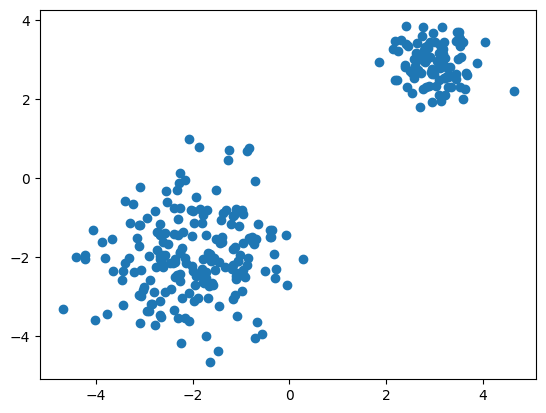

PyObject <matplotlib.collections.PathCollection object at 0x7f35b1870b00>

In [103]:
# Generate Data
N1 = 100
N2 = 200
Y = [randn(N1, 2)*.5 .+ 3; randn(N2, 2) .- 2]
plt.scatter(Y[:, 1], Y[:, 2])

In [104]:
chain = sample(MvGMM(Y, 5), HMC(0.01, 100), 201)

TypeError: TypeError: in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,12}